Final Project: Predicting Student Performance
===
Authors: John Sabo and Michael Shimer

Goal: Make a machine learning model that can predict how well a student will do in school.

In [ ]:
# IMPORTS

import ast

import numpy as np
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor, StackingClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# USEFUL METHODS

def read_student_data(filename):
    """
    Reads the CSV file from the current directory and changes all semi-colons to comas
    as well as removes all unnecessary quotes.
    """
    fixed_data = []
    file = open(filename)
    for line in file:
        line_data = line.strip().split(';')
        temp = []
        for item in line_data:
            item.strip('"')
            temp.append(item)
        fixed_data.append(temp)
    column_names = fixed_data[0]
    fixed_data.remove(fixed_data[0])
    file.close()

    return pd.DataFrame(fixed_data, columns=column_names) 


def split_labels(data, label_feature):
    """
    Split the given column of of the data, returning the full data set (without that
    feature) and the split off feature.
    """
    return data.drop(columns=label_feature), data[label_feature]

Frame the Problem and Look at the Big Picture 
===
1. Define the objective in business terms. 
    * The school is looking for a system that will predict how well a student will do to see if they can give them help earlier in the school year as opposed to later.
2. How will your solution be used? 
    * The model is going to be used to predict how well a student is doing or how well a student will do on their final grades.
    * Our solution will be used to find students who need additional help sooner rather than later.
3. What are the current solutions/workarounds (if any)? 
    * Predicting student performance is not a new idea, however, current methods used involve paper and pencil analysis.
4. How should you frame this problem (supervised/unsupervised, online/offline, ...)? 
    * Supervised - It will be a supervised learning model because we have a target feature or label.
        - The label is the students' final grade.
    * Regression - It will be a regression problem because grades are measured on a linear scale.
        - i.e. grades are '0 to 100' or 'F to A'
    * Offline - It will be offline because it will not recieve new data on a daily basis.
5. How should performance be measured? Is the performance measure aligned with the business objective? 
    * The root mean squared error will denote how close the model is to predicting the actual grade.
6. What would be the minimum performance needed to reach the business objective? 
    * To reach the business objective we will have a minimum performance requirement for the model of 10% error. In other words, the predicted final grade mnust always be within 10 points of the acutal grade.
7. What are comparable problems? Can you reuse experience or tools? 
    * Predicting an athlete performance based on factors in and off the field is a similar problem. There models that exist to predict performance of both students and athletes. Some models may exist that use some athletic data to predict the students performance. There are no tools or experience we can use to specifically help solve this problem, however, as our experience grows in Machine learning, we feel more ready for the task.
8. Is human expertise available? 
    * This project has no human expertise available.
9. How would you solve the problem manually? 
    * To solve this manually, all the features would be analyzed and given a weight based on how important each feature is determined to be. An alogrithm would be written to consider all the weights of the attributes and compute a numerical prediction for the final grade of the student.
10.  List the assumptions you (or others) have made so far. Verify assumptions if possible. 
    * So assumptions are being made against our data.

Get the Data
===

1. List the data you need and how much you need 
* The data for this project is student characteristics that will be used to predict their performance in school. This data set includes about 1000 different student samples. 
2. Find and document where you can get that data 
* The data is available on Kaggle: https://www.kaggle.com/datasets/impapan/student-performance-data-set
3. Get access authorizations
* the data is public 
4. Create a workspace (with enough storage space)
* this notebook
5. Get the data
* data is in student.csv file  
6. Convert the data to a format you can easily manipulate (without changing the data itself)
* data is loaded from the student.csv file into a pandas dataframe labeled "data"  
7. Ensure sensitive information is deleted or protected (e.g. anonymized) 
* there is no sensitive data included in this data set
8. Check the size and type of data (time series, geographical, ...) 
* The data has just over 1000 samples with 32 features each
    1. Is it a time series: Not a time series.
    2. Are any of the features not be available for the business problem? All features will be available for the business problem.
    3. Which feature(s) will be used as the target/label for the business problem? The label for the business problem is the grade for the feature "G3".
    4. Should any of the features be stratified during the train/test split to avoid sampling biases? None of the features need to be stratified.
* 
9. Sample a test set, put it aside, and never look at it (no data snooping!) 
* train and test sets are created

In [46]:
data = read_student_data('student.csv')

train_set, test_set = train_test_split(data, test_size=.15)

X_train, y_train = split_labels(train_set, "G3")
X_test, y_test = split_labels(test_set, "G3")

# Convert labels to integers
y_train = y_train.astype(str).astype(int)
y_test = y_test.astype(str).astype(int)

X_train_copy = X_train.copy()
y_train_copy = y_train.copy()


Explore the data
===
1. Copy the data for exploration, downsampling to a manageable size if necessary. 
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, 
bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); 
Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...) 
3. For supervised learning tasks, identify the target attribute(s) 
4. Visualize the data 
5. Study the correlations between attributes 
6. Study how you would solve the problem manually 
7. Identify the promising transformations you may want to apply 
8. Identify extra data that would be useful (go back to “Get the Data”) 
9. Document what you have learned 

In [47]:
X_train.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
count,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887
unique,2,2,8,2,2,2,5,5,5,5,4,3,4,4,4,2,2,2,2,2,2,2,2,5,5,5,5,5,5,35,18,17
top,"""GP""","""F""",16,"""U""","""GT3""","""T""",4,2,"""other""","""other""","""course""","""mother""",1,2,0,"""no""","""yes""","""no""","""no""","""yes""","""yes""","""yes""","""no""",4,3,3,1,1,5,0,"""10""","""11"""
freq,659,497,238,648,618,779,269,279,349,493,375,620,540,437,739,783,539,707,446,713,817,701,571,435,357,286,620,337,342,304,126,119


In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 1018 to 46
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      887 non-null    object
 1   sex         887 non-null    object
 2   age         887 non-null    object
 3   address     887 non-null    object
 4   famsize     887 non-null    object
 5   Pstatus     887 non-null    object
 6   Medu        887 non-null    object
 7   Fedu        887 non-null    object
 8   Mjob        887 non-null    object
 9   Fjob        887 non-null    object
 10  reason      887 non-null    object
 11  guardian    887 non-null    object
 12  traveltime  887 non-null    object
 13  studytime   887 non-null    object
 14  failures    887 non-null    object
 15  schoolsup   887 non-null    object
 16  famsup      887 non-null    object
 17  paid        887 non-null    object
 18  activities  887 non-null    object
 19  nursery     887 non-null    object
 20  higher  

In [50]:
for column in X_train.columns:
            if(X_train[column][0][0] != '"'):
                X_train[column] = X_train[column].astype(str).astype(int)

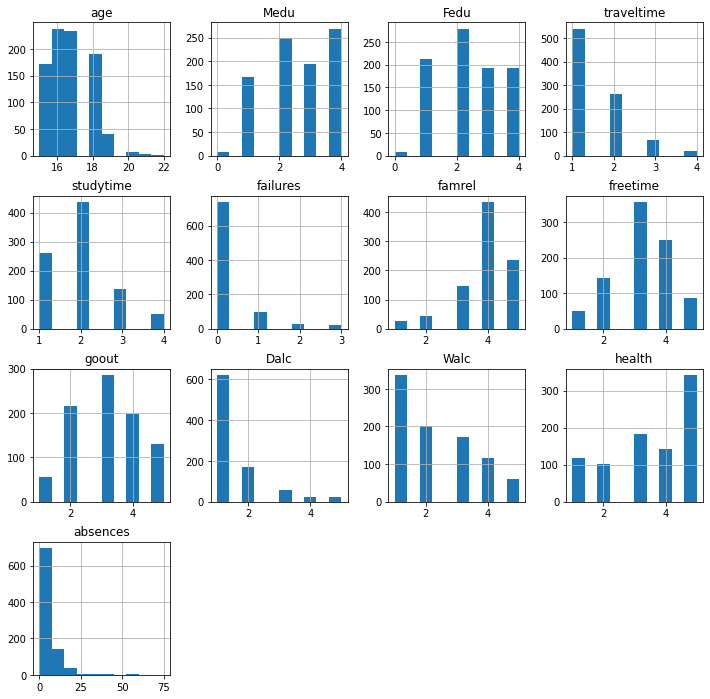

In [51]:
X_train.hist(figsize=(12, 12), bins=10);

<AxesSubplot:>

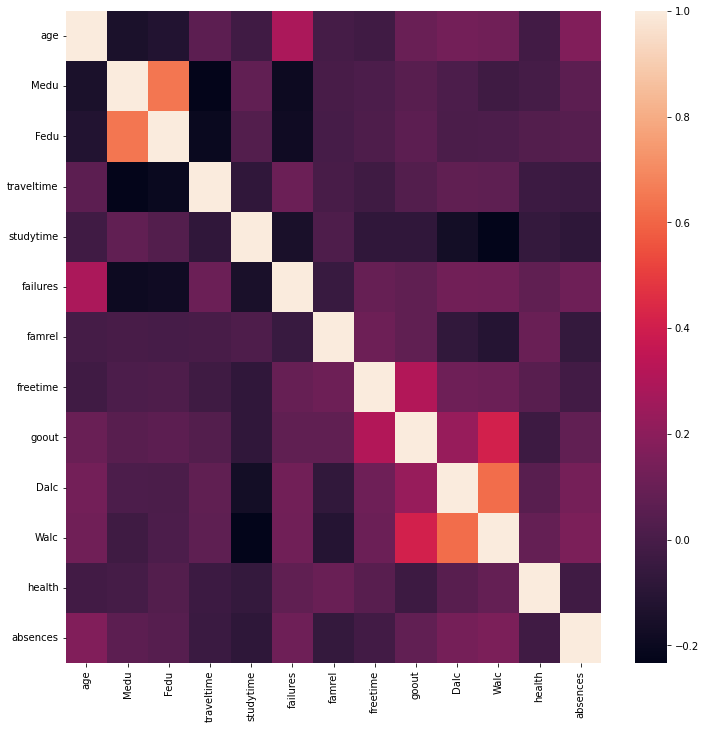

In [52]:
plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr())

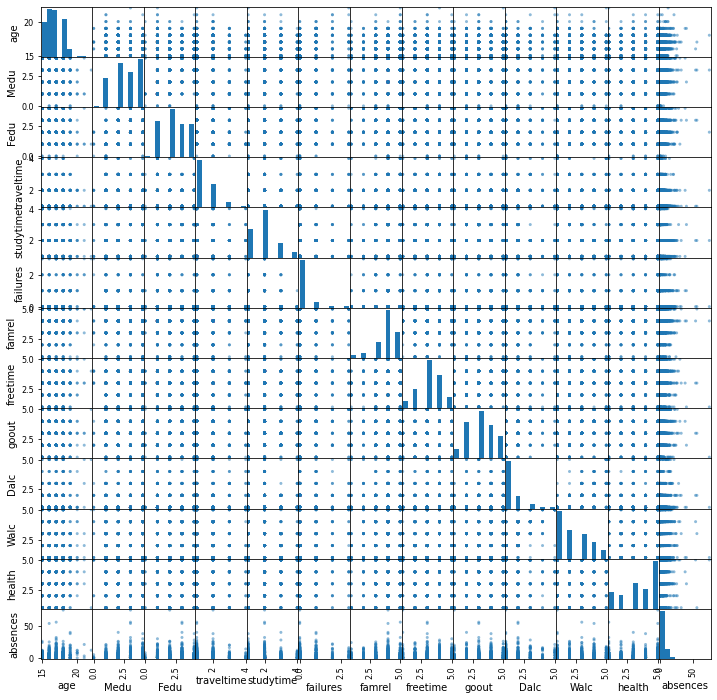

In [53]:
pd.plotting.scatter_matrix(X_train, figsize=(12,12));

Prepare the Data
===

In [54]:
# Cell for preprocessor classes

class RemoveUnwantedFeatures(BaseEstimator, TransformerMixin):
    """
    Drops the unwanted features. Since our target feature is the final grade we will not need
    the first and second semester grades. So this will remove "G1" and "G2".
    """
    def __init__(self, features=None):
        super().__init__()
        self.features = features

    def fit(self, X, y=None, **kwargs):
        
        return self

    def transform(self, X): return X.drop(columns=self.features)


class ConvertNumbersToIntegers(BaseEstimator, TransformerMixin):
    """
    Converts all numerical objects to objects of type int.
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        for column in X.columns:
            if(X[column][0][0] != '"'):
                X[column] = X[column].astype(str).astype(int)
        return X


class LogTransformData(BaseEstimator, TransformerMixin):
    """
    Takes the log of features to convert them from a log distribution to a normal distribution
    """
    def __init__(self, features=None):
        super().__init__()
        self.features = features

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        for feature in self.features:
            X[feature] = np.log(X[feature]+1)
        return X


class ConvertToDataFrame(BaseEstimator, TransformerMixin):
    """
    After running oneHotEncoder the DateFrame is converted to a numpy array, this function converts the 
    numpy array back into a DataFrame
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=["school_GP", "school_MS", "sex_F", "sex_M", "address_rural", "address_urban", "famsize_GT3", "famsize_LT3", "Pstatus_apart", "Pstatus_together",
    "Mjob_home", "Mjob_health", "Mjob_other", "Mjob_services", "Mjob_teacher", "Fjob_home", "Fjob_health", "Fjob_other", "Fjob_services", "Fjob_teacher",
    "guardian_father", "guardian_mother", "guardian_other", "reason_course", "reason_other", "reason_home", "reason_reputation", "schoolsup_no", "schoolsup_yes",
    "famsup_no", "famsup_yes", "paid_no", "paid_yes", "activities_no", "activites_yes", "nursery_no", "nursery_yes", "higher_no", "higher_yes",
    "internet_no", "internet_yes", "romantic_no", "romantic_yes", "age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime",
    "goout", "Dalc", "Walc", "health", "absences"])
        return X


In [57]:
X_train = X_train_copy
y_train = y_train_copy

preprocessor = Pipeline([

    ('drop_features', RemoveUnwantedFeatures(features=["G1", "G2"])),
    ('convert_to_int', ConvertNumbersToIntegers()),
    ('log_transform', LogTransformData(features=["traveltime", "failures", "Dalc", "absences"])),

    ('column_transform_one_hot', ColumnTransformer(transformers=[
        ('one_hot_encoder', OneHotEncoder(), ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian', 'reason',
        'schoolsup', 'famsup', 'paid', 'activities','nursery', 'higher', 'internet', 'romantic']),
    ], remainder='passthrough')),
    ('scaler', MinMaxScaler()),
    ('convert_to_dataframe', ConvertToDataFrame())

])


preprocessor.fit_transform(X_train, y_train)

,school_GP,school_MS,sex_F,sex_M,address_rural,address_urban,famsize_GT3,famsize_LT3,Pstatus_apart,Pstatus_together,Mjob_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,guardian_father,guardian_mother,guardian_other,reason_course,reason_other,reason_home,reason_reputation,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activites_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.428571,1.00,1.00,0.442507,0.666667,0.0,0.75,0.25,0.25,0.369070,0.25,1.00,0.000000
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.285714,0.75,1.00,0.000000,0.666667,0.0,0.75,0.75,1.00,0.000000,0.50,1.00,0.654211
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.00,0.75,0.000000,0.333333,0.0,0.75,1.00,0.25,0.000000,0.00,1.00,0.000000
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.428571,0.50,0.75,0.000000,0.666667,0.0,0.75,0.50,0.50,0.000000,0.25,0.50,0.371632
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.285714,0.50,0.50,0.000000,0.666667,0.0,0.50,0.50,0.25,0.369070,0.25,0.50,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.00,1.00,0.000000,0.666667,0.0,0.75,0.50,0.50,0.000000,0.00,1.00,0.371632
883,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.285714,0.50,0.75,0.442507,0.000000,0.0,1.00,0.25,0.25,0.000000,0.00,0.25,0.371632
884,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.142857,0.25,0.25,0.442507,0.000000,0.0,0.75,0.25,0.25,0.834044,0.50,0.25,0.000000
885,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.142857,1.00,1.00,0.000000,0.000000,0.0,0.50,0.75,0.75,0.000000,0.75,1.00,0.371632


Short-list Promising
===